In [25]:
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

## Design Idea

In [2]:
span = 1701
offset = -17
slice_heigth = 108

(1913, 2048, 3)


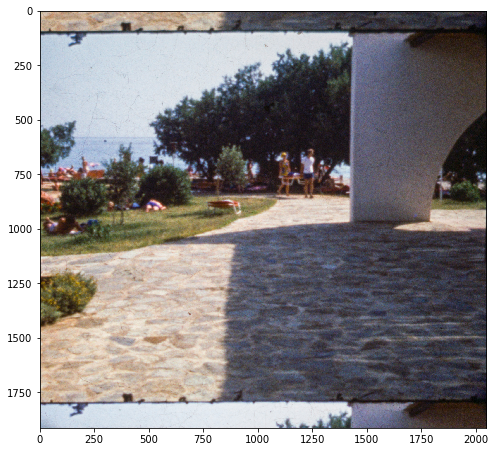

In [3]:
imgpath = "/Volumes/PortableSSD/cleaned_stab_test_all/frame-00702.jpg"
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(8,8))
plt.imshow(img, interpolation="none")
plt.show()

In [4]:
def extract_sample(frame, span=2540, offset=-25, slice_heigth=161):
    bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    normed = bw / 255
    
    middle = normed.shape[0] / 2
    upper = middle + offset - span / 2
    lower = middle + offset + span / 2

    upper_slice = normed[int(upper-slice_heigth/2):int(upper+slice_heigth/2),:]
    lower_slice = normed[int(lower-slice_heigth/2):int(lower+slice_heigth/2),:]

    upper_squashed = cv2.resize(upper_slice, (slice_heigth,slice_heigth))
    lower_squashed = cv2.resize(lower_slice, (slice_heigth,slice_heigth))

    sample = np.stack([upper_squashed,lower_squashed])
    sample = np.moveaxis(sample, 0, -1)
    return sample

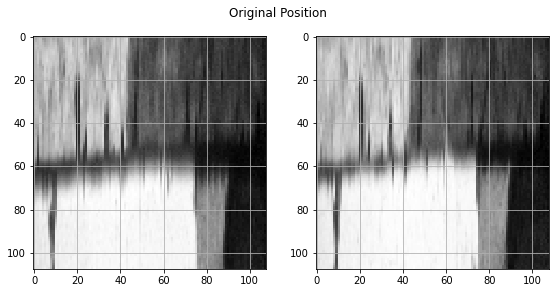

In [5]:
sample = extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.suptitle("Original Position")
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

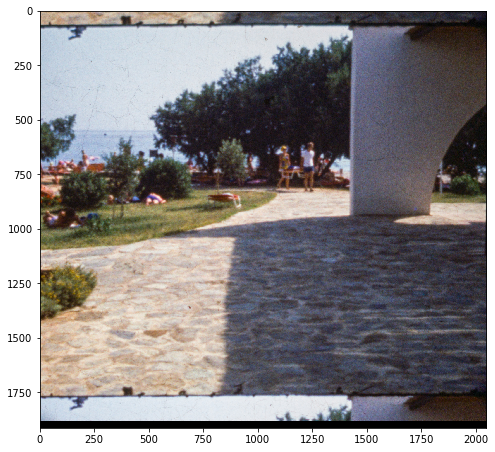

In [6]:
weave = -30
M = np.float32([
    [1, 0,      0],
    [0, 1, weave]
])
weaved = cv2.warpAffine(img, M, (img.shape[1],img.shape[0]))

plt.figure(figsize=(8,8))
plt.imshow(weaved, interpolation="none")
plt.show()

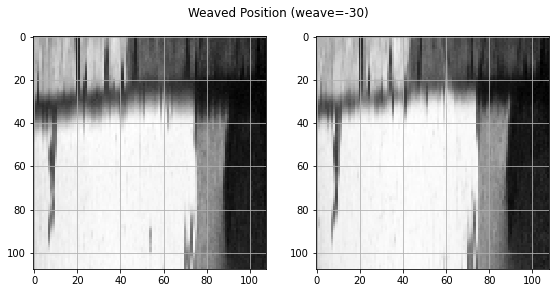

In [7]:
sample = extract_sample(weaved, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.suptitle(f"Weaved Position (weave={weave})")
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

## Create Training Data

In [8]:
def create_train_sample(img, span, offset, slice_heigth, max_weave):
    weave = np.random.uniform(-max_weave,max_weave)
    M = np.float32([
        [1, 0,      0],
        [0, 1, weave]
    ])
    weaved = cv2.warpAffine(img, M, (img.shape[1],img.shape[0]))

    original_sample = extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth)
    weaved_sample = extract_sample(weaved, span=span, offset=offset, slice_heigth=slice_heigth)

    return original_sample, weaved_sample, weave

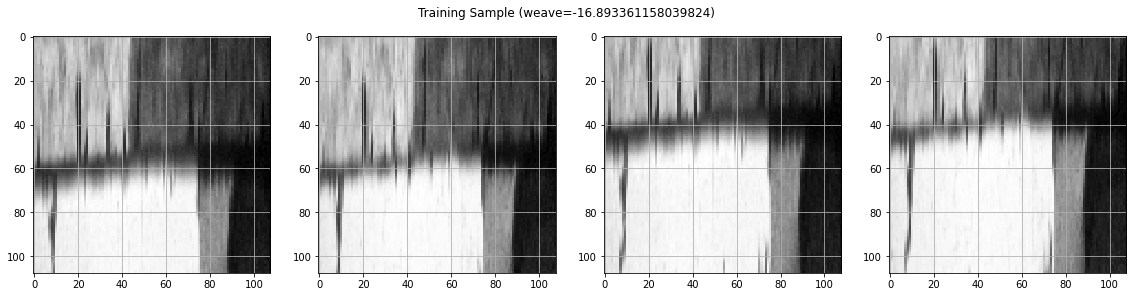

In [9]:
original, weaved, weave = create_train_sample(img, span=span, offset=offset,
                                              slice_heigth=slice_heigth, max_weave=30)

plt.figure(figsize=(16,4))
plt.suptitle(f"Training Sample (weave={weave})")
plt.subplot(141)
plt.imshow(original[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(142)
plt.imshow(original[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(143)
plt.imshow(weaved[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(144)
plt.imshow(weaved[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

## Preprocess Dataset

In [10]:
directory = "/Volumes/PortableSSD/cleaned_stab_test_all"
imgpaths = sorted(glob.glob(os.path.join(directory, "frame-*.jpg")))
print(len(imgpaths))
print(imgpaths[:5])

3615
['/Volumes/PortableSSD/cleaned_stab_test_all/frame-00000.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00001.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00002.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00003.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00004.jpg']


In [20]:
samples = []
for imgpath in tqdm(imgpaths):
    bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    sample = create_train_sample(rgb, span=span, offset=offset, slice_heigth=slice_heigth,
                                 max_weave=30)
    samples.append(sample)

100%|██████████| 3615/3615 [08:09<00:00,  7.38it/s]


In [22]:
Xa = np.array([sample[0] for sample in samples]).astype("float32")
Xb = np.array([sample[1] for sample in samples]).astype("float32")
y = np.array([sample[2] for sample in samples]).astype("float32")
Xa.shape

(3615, 108, 108, 2)

In [23]:
with open("Xa_cretecleaned.npy", "wb") as f:
    np.save(f, Xa)
with open("Xb_cretecleaned.npy", "wb") as f:
    np.save(f, Xb)
with open("y_cretecleaned.npy", "wb") as f:
    np.save(f, y)

In [26]:
test_samples = []
for imgpath in tqdm(random.choices(imgpaths, k=1000)):
    bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    sample = create_train_sample(rgb, span=span, offset=offset, slice_heigth=slice_heigth,
                                 max_weave=30)
    test_samples.append(sample)

100%|██████████| 1000/1000 [02:24<00:00,  6.90it/s]


In [27]:
Xa_test = np.array([sample[0] for sample in test_samples]).astype("float32")
Xb_test = np.array([sample[1] for sample in test_samples]).astype("float32")
y_test = np.array([sample[2] for sample in test_samples]).astype("float32")
Xa_test.shape

(1000, 108, 108, 2)

In [28]:
with open("Xa_test_cretecleaned.npy", "wb") as f:
    np.save(f, Xa_test)
with open("Xb_test_cretecleaned.npy", "wb") as f:
    np.save(f, Xb_test)
with open("y_test_cretecleaned.npy", "wb") as f:
    np.save(f, y_test)

## Train

In [29]:
with open("Xa_cretecleaned.npy", "rb") as f:
    Xa = np.load(f)
with open("Xb_cretecleaned.npy", "rb") as f:
    Xb = np.load(f)
with open("y_cretecleaned.npy", "rb") as f:
    y = np.load(f)

In [30]:
with open("Xa_test_cretecleaned.npy", "rb") as f:
    Xa_test = np.load(f)
with open("Xb_test_cretecleaned.npy", "rb") as f:
    Xb_test = np.load(f)
with open("y_test_cretecleaned.npy", "rb") as f:
    y_test = np.load(f)

In [36]:
input_a = keras.Input(shape=(slice_heigth,slice_heigth,2))
input_b = keras.Input(shape=(slice_heigth,slice_heigth,2))

conv1 = layers.Conv2D(16, (5,25), strides=(1,4), activation="relu")
conv2 = layers.Conv2D(8, (3,15), strides=(1,3), activation="relu")
flatten = layers.Flatten()
dense1 = layers.Dense(32, activation="relu")
pos = layers.Dense(1)

a = conv1(input_a)
a = conv2(a)
a = flatten(a)
a = dense1(a)
a = pos(a)

b = conv1(input_b)
b = conv2(b)
b = flatten(b)
b = dense1(b)
b = pos(b)

out = layers.Subtract()([b,a])

model = keras.Model(inputs=[input_a,input_b], outputs=out)

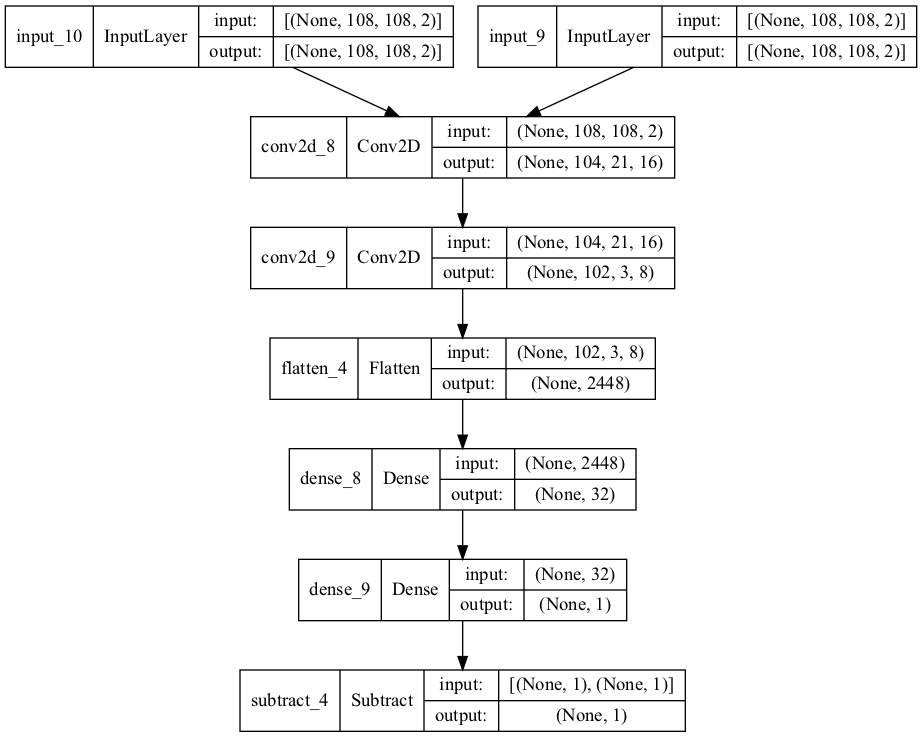

In [37]:
keras.utils.plot_model(model, show_shapes=True)

In [38]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 108, 108, 2  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 108, 108, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 104, 21, 16)  4016        ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

In [39]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit([Xa,Xb], y, epochs=50, shuffle=True, validation_data=([Xa_test,Xb_test],y_test))

Epoch 1/50
113/113 [==============================] - 20s 174ms/step - loss: 77.2602 - mae: 5.9227 - val_loss: 25.2728 - val_mae: 3.3159
Epoch 2/50
113/113 [==============================] - 20s 175ms/step - loss: 26.8741 - mae: 3.5509 - val_loss: 24.0054 - val_mae: 3.3886
Epoch 3/50
113/113 [==============================] - 23s 200ms/step - loss: 20.6892 - mae: 3.0945 - val_loss: 15.1985 - val_mae: 2.5455
Epoch 4/50
113/113 [==============================] - 18s 160ms/step - loss: 16.9691 - mae: 2.8007 - val_loss: 14.8851 - val_mae: 2.4726
Epoch 5/50
113/113 [==============================] - 15s 135ms/step - loss: 14.4766 - mae: 2.5698 - val_loss: 11.0178 - val_mae: 2.1687
Epoch 6/50
113/113 [==============================] - 17s 149ms/step - loss: 12.3043 - mae: 2.3667 - val_loss: 11.3925 - val_mae: 2.1632
Epoch 7/50
113/113 [==============================] - 16s 145ms/step - loss: 8.7012 - mae: 1.9808 - val_loss: 7.6260 - val_mae: 1.7380
Epoch 8/50
113/113 [=======================

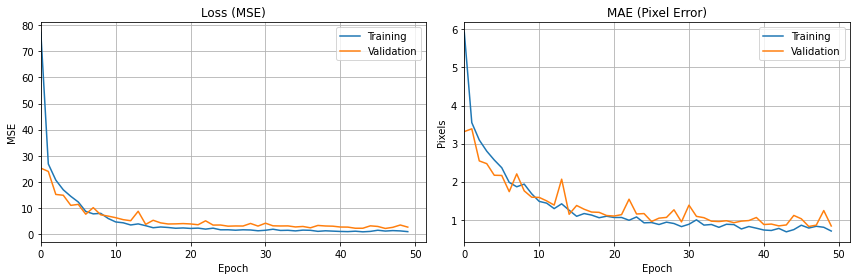

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlim(0, None)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.subplot(122)
plt.title("MAE (Pixel Error)")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlim(0, None)
plt.xlabel("Epoch")
plt.ylabel("Pixels")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
model.save("model_cretecleaned_test01")

2021-11-15 20:06:23.097642: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_cretecleaned_test01/assets


/usr/local/Caskroom/miniconda/base/envs/8mm/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/Caskroom/miniconda/base/envs/8mm/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Generate Stabilised Video

In [42]:
model = keras.models.load_model("model_cretecleaned_test01")

In [63]:
directory = "/Volumes/PortableSSD/cleaned_stab_test_all"
imgpaths = sorted(glob.glob(os.path.join(directory, "frame-*.jpg")))[680:730]
print(len(imgpaths))
print(imgpaths[:5])

50
['/Volumes/PortableSSD/cleaned_stab_test_all/frame-00680.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00681.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00682.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00683.jpg', '/Volumes/PortableSSD/cleaned_stab_test_all/frame-00684.jpg']


In [66]:
# ref = cv2.imread(imgpaths[0], cv2.IMREAD_COLOR)
# ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
# Xa = extract_sample(ref, span=span, offset=offset, slice_heigth=slice_heigth)
# Xa = np.expand_dims(Xa, axis=0)

bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

Xa = extract_sample(rgb, span=span, offset=offset, slice_heigth=slice_heigth)
Xa = np.expand_dims(Xa, axis=0)

weaves = []
for imgpath in tqdm(imgpaths):
    bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Xb = extract_sample(rgb, span=span, offset=offset, slice_heigth=slice_heigth)
    Xb = np.expand_dims(Xb, axis=0)

    y = model.predict([Xa,Xb])

    weave = y.squeeze()
    weaves.append(weave)

    M = np.float32([
        [1, 0,      0],
        [0, 1, -weave]
    ])
    shifted = cv2.warpAffine(bgr, M, (bgr.shape[1],bgr.shape[0]))

    dstpath = imgpath[:-16] + "_laststabbed" + imgpath[-16:]
    cv2.imwrite(dstpath, shifted)

    rgb = cv2.cvtColor(shifted, cv2.COLOR_BGR2RGB)
    Xa = extract_sample(rgb, span=span, offset=offset, slice_heigth=slice_heigth)
    Xa = np.expand_dims(Xa, axis=0)

100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


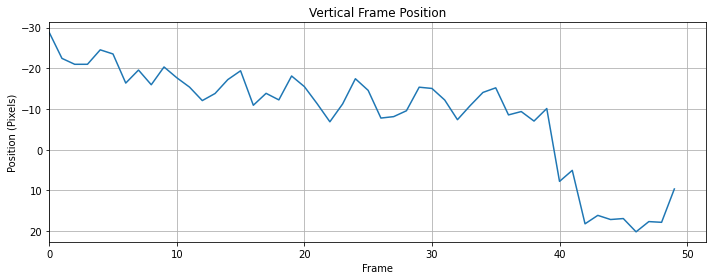

In [67]:
plt.figure(figsize=(10,4))
plt.title("Vertical Frame Position")
plt.plot(weaves)
plt.xlim(0, None)
plt.xlabel("Frame")
plt.ylabel("Position (Pixels)")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

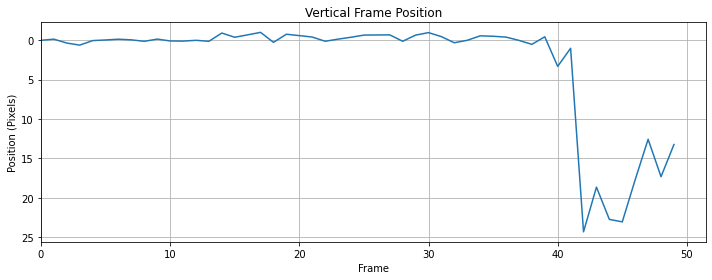

In [61]:
plt.figure(figsize=(10,4))
plt.title("Vertical Frame Position")
plt.plot(weaves)
plt.xlim(0, None)
plt.xlabel("Frame")
plt.ylabel("Position (Pixels)")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

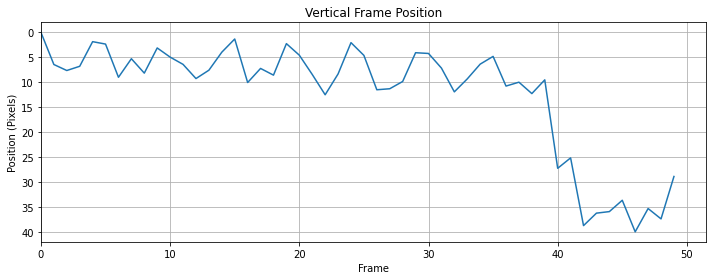

In [58]:
plt.figure(figsize=(10,4))
plt.title("Vertical Frame Position")
plt.plot(weaves)
plt.xlim(0, None)
plt.xlabel("Frame")
plt.ylabel("Position (Pixels)")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()